# Fitting the Brick 23 IR CMD (v3)

In this experiment I'll constrain the solution to solar metallicity with $\pm 0.1$ dex of 'fuzz' in the metallicity. We'll also include young ages with binning.

In [35]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %config InlineBackend.figure_format='svg'

import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import time
from glob import glob
import numpy as np

brick = 23
STARFISH = os.getenv("STARFISH")
isoc_dir = "b23ir3_isoc"
lib_dir = "b23ir3_lib"
synth_dir = "b23ir3_synth"
fit_dir = "b23ir3_fit"
wfc3_bands = ['F110W', 'F160W']

## Download Isochrones

We use a log-space age grid for ages less than a billion years, and a linear grid of every 0.5 Gyr thereafter.

In [36]:
from astropy.coordinates import Distance
import astropy.units as u

from padova import AgeGridRequest, IsochroneRequest
from starfisher import LibraryBuilder

z_grid = [0.015, 0.019, 0.024]
delta_gyr = 0.5
late_ages = np.log10(np.arange(1e9 + delta_gyr, 13e9, delta_gyr * 1e9))
if not os.path.exists(os.path.join(STARFISH, isoc_dir)):
    for z in z_grid:
        # Young ages in log-grid
        r = AgeGridRequest(z,
                           min_log_age=6.6,
                           max_log_age=8.5,
                           delta_log_age=0.1,
                           phot='wfc3', photsys_version='odfnew')
        for isoc in r.isochrone_set:
            isoc.export_for_starfish(os.path.join(STARFISH, isoc_dir),
                                     bands=wfc3_bands)
        
        # Old ages in linear grid
        for logage in late_ages:
            r = IsochroneRequest(z, logage,
                                 phot='wfc3', photsys_version='odfnew')
            r.isochrone.export_for_starfish(os.path.join(STARFISH, isoc_dir),
                                     bands=wfc3_bands)

d = Distance(785 * u.kpc)
builder = LibraryBuilder(isoc_dir, lib_dir,
                         nmag=len(wfc3_bands),
                         dmod=d.distmod.value,
                         iverb=3)
if not os.path.exists(builder.full_isofile_path):
    builder.install()

Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from cache
Reading from

## Build the Isochrone Library and Synthesize CMD planes

In [46]:
from collections import namedtuple
from starfisher import Lockfile
from starfisher import Synth
from starfisher import ExtinctionDistribution
from starfisher import ExtantCrowdingTable
from starfisher import ColorPlane
from m31hst.phatast import PhatAstTable

if not os.path.exists(os.path.join(STARFISH, synth_dir)):
    os.makedirs(os.path.join(STARFISH, synth_dir))

# No binning in our lockfile
lockfile = Lockfile(builder.read_isofile(), synth_dir, unbinned=False)

# Bin young isochrones
young_grid = np.linspace(6.5, 8.9, 5)
for i, logage0 in enumerate(young_grid[:-1]):
    logage1 = young_grid[i + 1] - 0.05
    z_str = "0019"
    mean_age = (logage0 + logage1) / 0.2
    name = "z{0}_{1:05.2f}".format(z_str, mean_age)
    lockfile.lock_box(name, (logage0, logage1), (0.014, 0.025))

# Bin old isochrones
old_grid = np.arange(1e9, 14 * 1e9, 1e9)
for i, age0 in enumerate(old_grid[:-1]):
    logage0 = np.log10(age0 - 0.05 * 1e9)
    logage1 = np.log10(old_grid[i + 1])
    z_str = "0019"
    mean_age = (logage0 + logage1) / 0.2
    name = "z{0}_{1:05.2f}".format(z_str, mean_age)
    lockfile.lock_box(name, (logage0, logage1), (0.014, 0.025))

Here we visualize the isochrone bins in $\log(\mathrm{age})$ space.

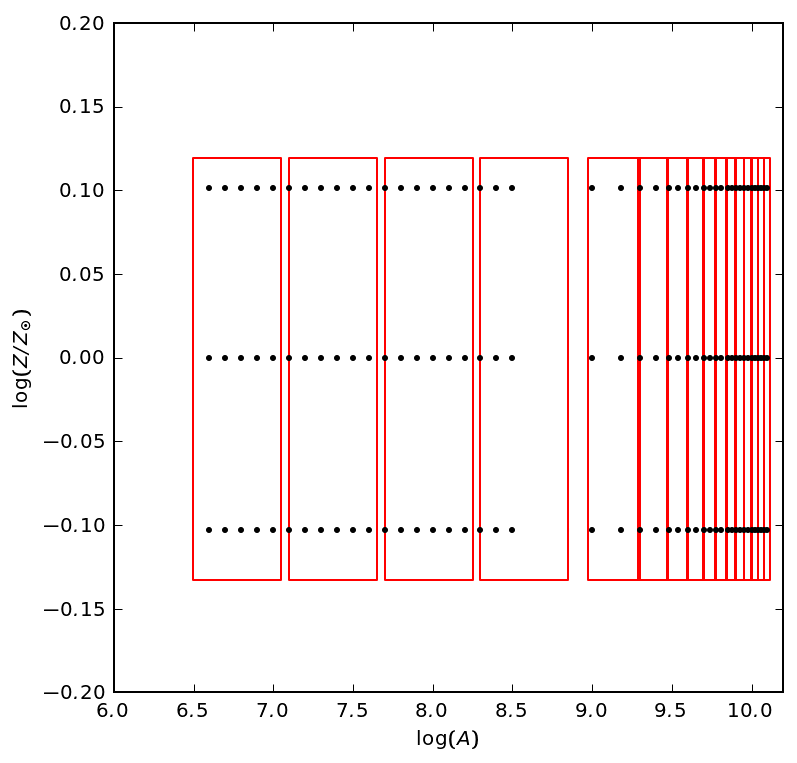

In [38]:
from starfisher.plots import plot_lock_polygons, plot_isochrone_logage_logzsol

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
plot_isochrone_logage_logzsol(ax, builder, c='k', s=8)
plot_lock_polygons(ax, lockfile, facecolor='None', edgecolor='r')
ax.set_xlim(6, 10.2)
ax.set_ylim(-0.2, 0.2)
ax.set_xlabel(r"$\log(A)$")
ax.set_ylabel(r"$\log(Z/Z_\odot)$")
fig.show()

In [39]:
# No extinction, yet
young_av = ExtinctionDistribution()
old_av = ExtinctionDistribution()
rel_extinction = np.ones(len(wfc3_bands), dtype=float)
for av in (young_av, old_av):
    av.set_uniform(0.)

# Use PHAT AST from the outer field
crowd_path = os.path.join(synth_dir, "crowding.dat")
full_crowd_path = os.path.join(STARFISH, crowd_path)
tbl = PhatAstTable()
tbl.write_crowdfile_for_field(full_crowd_path, 0)
crowd = ExtantCrowdingTable(crowd_path)

# Define CMD planes
Lim = namedtuple('Lim', 'x y')
ir_lim = Lim(x=(0.3, 1.3), y=(24, 16.5))
ir_cmd = ColorPlane((wfc3_bands.index('F110W'),
                     wfc3_bands.index('F160W')),
                    wfc3_bands.index('F160W'),
                    ir_lim.x,
                    (min(ir_lim.y), max(ir_lim.y)),
                    28.,
                    suffix='f110f160',
                    x_label=r'$\mathrm{F110W}-\mathrm{F160W}$',
                    y_label=r'$\mathrm{F110W}$',
                    dpix=0.05)
ir_cmd.mask_region((-1., 0.), (22., 16))
ir_cmd.mask_region((0, 0.3), (22., 16))
ir_cmd.mask_region((0.3, 0.7), (20., 16))
ir_cmd.mask_region((0.7, 0.8), (19., 16))
ir_cmd.mask_region((0.8, 0.9), (18., 16))
ir_cmd.mask_region((1.1, 1.5), (28, 21))
colour_planes = [ir_cmd]

synth = Synth(synth_dir, builder, lockfile, crowd,
              rel_extinction,
              young_extinction=young_av,
              old_extinction=old_av,
              planes=colour_planes,
              mass_span=(0.08, 150.),
              nstars=10000000)
if len(glob(os.path.join(STARFISH, synth_dir, "z*"))) == 0:
    synth.run_synth(n_cpu=4)
    synth.plot_all_hess(os.path.join(STARFISH, synth_dir, 'hess'))

nx 20
ny 150
x.shape (150, 20)
./synth < b23ir3_synth/synth.0.txt
./synth < b23ir3_synth/synth.1.txt
./synth < b23ir3_synth/synth.2.txt
./synth < b23ir3_synth/synth.3.txt


## Export the dataset for StarFISH

In [40]:
from astropy.table import Table
from m31hst import phat_v2_phot_path

if not os.path.exists(os.path.join(STARFISH, fit_dir)):
    os.makedirs(os.path.join(STARFISH, fit_dir))

data_root = os.path.join(fit_dir, "b23ir.")
full_data_path = os.path.join(STARFISH, '{0}f110f160'.format(data_root))
brick_table = Table.read(phat_v2_phot_path(brick), format='fits')

# Only use stars within the fitting box
c = brick_table['f110w_vega'] - brick_table['f160w_vega']
m = brick_table['f160w_vega']
sel = np.where((c > min(ir_lim.x)) & (c < max(ir_lim.x)) &
               (m > min(ir_lim.y)) & (m < max(ir_lim.y)))[0]
brick_table = brick_table[sel]

print("Fitting {0:d} stars".format(len(brick_table)))

if not os.path.exists(full_data_path):
    phot_dtype = np.dtype([('x', np.float), ('y', np.float)])
    photdata = np.empty(len(brick_table), dtype=phot_dtype)
    photdata['x'][:] = brick_table['f110w_vega'] - brick_table['f160w_vega']
    photdata['y'][:] = brick_table['f160w_vega']    
    np.savetxt(full_data_path, photdata, delimiter=' ', fmt='%.4f')

/Users/jsick/phat_data
Fitting 480492 stars


{'origin': 'lower', 'extent': [0.3, 1.3, 24, 16.5], 'vmin': None, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x109835b10>, 'aspect': 'auto', 'vmax': None, 'alpha': None, 'norm': None, 'interpolation': 'none'}


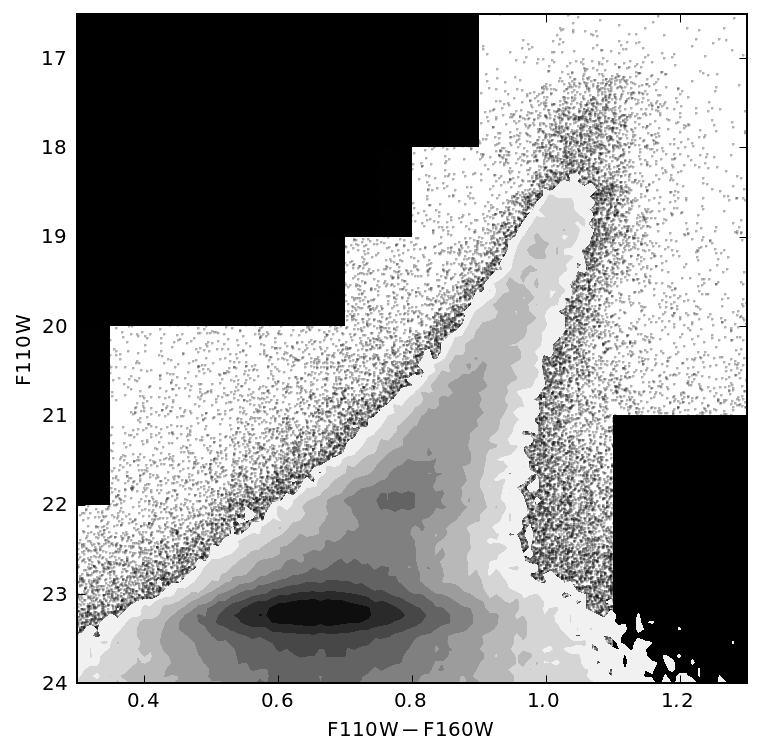

In [41]:
from androcmd.plot import contour_hess

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
contour_hess(ax, brick_table['f110w_vega'] - brick_table['f160w_vega'],
             brick_table['f160w_vega'], ir_lim.x, (max(ir_lim.y), min(ir_lim.y)),
             plot_args={'ms': 3})
ir_cmd.plot_mask(ax)
ax.set_xlabel(r'$\mathrm{F110W}-\mathrm{F160W}$')
ax.set_ylabel(r'$\mathrm{F110W}$')
ax.set_xlim(ir_lim.x)
ax.set_ylim(ir_lim.y)
fig.show()

## Run StarFISH SFH

In [42]:
from starfisher import SFH, Mask

mask = Mask(colour_planes)
sfh = SFH(data_root, synth, mask, fit_dir)
if not os.path.exists(sfh.full_outfile_path):
    sfh.run_sfh()
sfh_table = sfh.solution_table()

### Visualization of the SFH

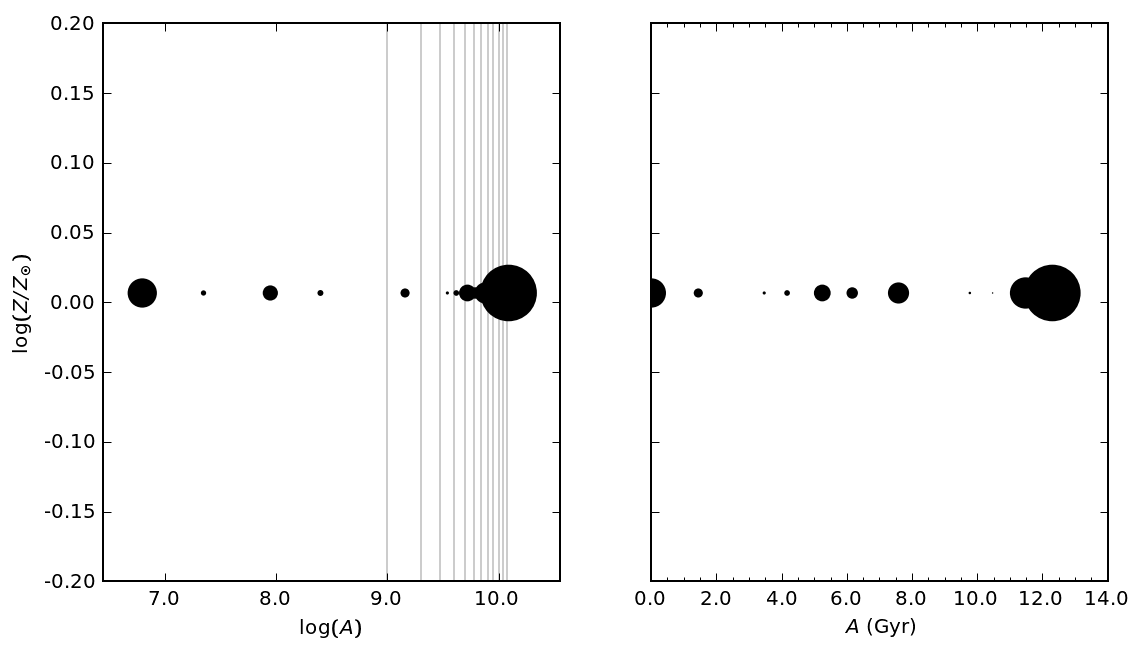

In [52]:
from starfisher.sfhplot import LinearSFHCirclePlot, SFHCirclePlot

fig = plt.figure(figsize=(9, 5))
ax_log = fig.add_subplot(121)
ax_lin = fig.add_subplot(122)

cp = SFHCirclePlot(sfh_table)
cp.plot_in_ax(ax_log, max_area=800)
for logage in np.log10(np.arange(1, 13, 1) * 1e9):
    ax_log.axvline(logage, c='0.8', zorder=-1)
ax_log.set_ylim(-0.2, 0.2)

cp = LinearSFHCirclePlot(sfh_table)
cp.plot_in_ax(ax_lin, max_area=800)
for tl in ax_lin.get_ymajorticklabels():
    tl.set_visible(False)
ax_lin.set_ylabel("")
ax_lin.set_ylim(-0.2, 0.2)
fig.show()

### Comparison of Observed and Modelled CMDs

{'origin': 'lower', 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x110ddbe10>, 'extent': [0.3, 1.3, 24, 16.5], 'aspect': 'auto', 'interpolation': 'none'}
{'origin': 'lower', 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10d754d50>, 'extent': [0.3, 1.3, 24, 16.5], 'aspect': 'auto', 'interpolation': 'none'}
{'origin': 'lower', 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11860b790>, 'extent': [0.3, 1.3, 24, 16.5], 'aspect': 'auto', 'interpolation': 'none'}


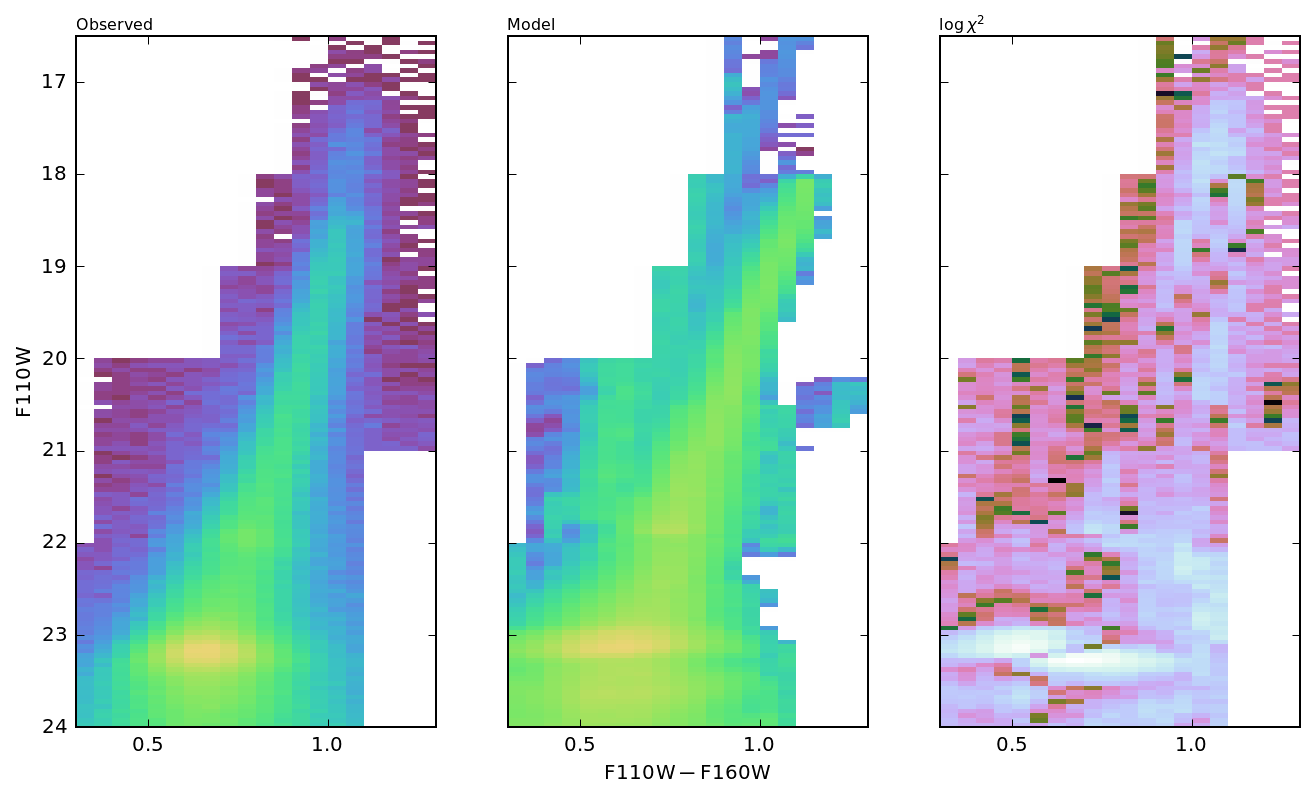

In [54]:
import cubehelix
cmapper = lambda: cubehelix.cmap(startHue=240,endHue=-300,minSat=1,maxSat=2.5,
                                 minLight=.3,maxLight=.8,gamma=.9)

from starfisher.sfhplot import ChiTriptykPlot
fig = plt.figure(figsize=(10, 6))
ctp = ChiTriptykPlot(sfh.full_chi_path, 1, ir_cmd.x_span, ir_cmd.y_span,
                     ir_cmd.dpix, ir_cmd.x_label, ir_cmd.y_label,
                    flipy=True)
ax_obs, ax_mod, ax_chi = ctp.setup_axes(fig)
ctp.plot_obs_in_ax(ax_obs, cmap=cmapper())
ctp.plot_mod_in_ax(ax_mod, cmap=cmapper())
ctp.plot_chi_in_ax(ax_chi, cmap=cubehelix.cmap())
ax_obs.text(0.0, 1.01, "Observed", transform=ax_obs.transAxes, size=8, ha='left')
ax_mod.text(0.0, 1.01, "Model", transform=ax_mod.transAxes, size=8, ha='left')
ax_chi.text(0.0, 1.01, r"$\log \chi^2$", transform=ax_chi.transAxes, size=8, ha='left')
fig.show()